# Recommender Systems

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('ratings.csv', sep=',')
data = shuffle(data)
data.head()

,movie_id,user_id,rating
122075,450,94,3.0
106461,354,1036,1.0
140686,550,1341,1.0
163565,734,654,3.0
138440,530,1120,1.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 122075 to 71769
Data columns (total 3 columns):
movie_id    200000 non-null int64
user_id     200000 non-null int64
rating      200000 non-null float64
dtypes: float64(1), int64(2)
memory usage: 6.1 MB


In [4]:
data.describe()

,movie_id,user_id,rating
count,200000.000000,200000.000000,200000.000000
mean,424.530130,932.984750,2.264930
std,330.797529,541.660646,1.494531
min,0.000000,0.000000,1.000000
25%,174.000000,446.000000,1.000000
50%,321.000000,942.500000,1.000000
75%,630.000000,1389.000000,4.000000
max,1681.000000,1885.000000,5.000000


In [5]:
X_train = data.loc[:,['movie_id', 'user_id']].values[:160000,:]
Y_train = data.loc[:,['rating']].values[:160000,:]

X_test = data.loc[:,['movie_id', 'user_id']].values[160000:,:]
Y_test = data.loc[:,['rating']].values[160000:,:]

In [6]:
class Layer1():
    
    def __init__(self, model, input_dim, rank):
        self.model = model
        self.input_dim = input_dim
        self.rank = rank
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.input_dim,self.rank))
        self.weights = [self.w]

    def __call__(self, inputs):        
        idx = tf.reshape(tf.cast(tf.abs(inputs), dtype='int32'),[-1])
        return tf.gather(self.w, indices=idx, axis=0)
    
class Layer2():
    
    def __init__(self, model):
        self.model = model
        self.build()
        
    def build(self):
        self.weights = []
        
    def __call__(self, inputs):
        a1 = inputs[0]
        a2 = inputs[1]
        return tf.concat(values=[a1,a2], axis=1)
    
class Layer3():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        u = tf.transpose(z)
        return tf.math.maximum(0.,u)
    
class Layer4():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        u = tf.transpose(z)
        return 4*tf.math.sigmoid(u)+1

In [7]:
class LossFunction():
        
    def __init__(self, model, alpha):
        self.model = model
        self.alpha = alpha
            
    def __call__(self, y_true, y_pred):
        loss = tf.reduce_mean(tf.square(y_true-y_pred))
        regularization = 0
        for i in range(len(self.model.weights)):
            regularization = regularization + tf.reduce_sum(tf.math.square(self.model.weights[i]))
        return loss + self.alpha*regularization

In [8]:
class MetricFunction():
                    
    def __init__(self, model):
        self.model = model
        
    def __call__(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true-y_pred))

In [9]:

class Optimizer():

    def __init__(self, model, learning_rate, beta_1, beta_2, epsilon):
        self.model = model
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon= epsilon
        self.stop_training = False
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.zeros(shape=shape, dtype="float32")
        return  tf.Variable(initial_value=weight_init, trainable=False)
    
    def build(self):
        self.weights = []
        for weight in self.model.weights:
            m = self.add_weight(shape=weight.shape)
            v = self.add_weight(shape=weight.shape)
            self.weights.append([m,v])
            
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            m = self.weights[i][0]
            v = self.weights[i][1]
            self.weights[i][0].assign(self.beta_1*m + (1-self.beta_1)*grad_w)  
            self.weights[i][1].assign(self.beta_2*v + (1-self.beta_2)*grad_w*grad_w)
            m_ = (1/(1-self.beta_1))*self.weights[i][0]
            v_ = (1/(1-self.beta_2))*self.weights[i][1]
            weights[i].assign(w - self.learning_rate*m_/(tf.math.sqrt(v_)+self.epsilon))
            
    def train_step(self, X, Y):
        with tf.GradientTape() as tape:
            H = self.model(X)
            loss = self.model.loss(Y, H)
        grads = tape.gradient(loss, self.model.weights)
        self.apply(grads, self.model.weights)
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [10]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [11]:
class RecommenderSystem():
    
    def __init__(self, movies_dim, users_dim, rank, hidden_dim, output_dim):
        self.movies_dim = movies_dim
        self.users_dim = users_dim
        self.rank = rank
        self.hidden_dim = hidden_dim
        self.ouput_dim = output_dim
        self.build()
     
    def build(self):
        self.h1 = Layer1(model=self, input_dim=self.movies_dim, rank=self.rank)
        self.h2 = Layer1(model=self, input_dim=self.users_dim, rank=self.rank)
        self.h3 = Layer2(model=self)
        self.h4 = Layer3(model=self, input_dim=2*self.rank, output_dim=self.hidden_dim)
        self.h5 = Layer4(model=self, input_dim=self.hidden_dim, output_dim=self.ouput_dim)
        self.layers = [self.h1, self.h2, self.h3, self.h4, self.h5]
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):
        x0 = inputs[0]
        x1 = self.h1(x0)
        z0 = inputs[1]
        z1 = self.h2(z0)
        y0 = self.h3([x1,z1]) 
        y1 = self.h4(y0)
        y2 = self.h5(y1)
        return y2
        
    def train_setup(self, epochs, learning_rate, alpha, beta_1, beta_2, epsilon, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.verbose = verbose
        self.loss = LossFunction(model=self, alpha=self.alpha)
        self.metric = MetricFunction(model=self)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon)
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=100, error=0.0001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=200, error=0.0001)]

    def fit(self, X, Y, epochs=1000, learning_rate=0.01, alpha=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, verbose=True):
        self.train_setup(epochs, learning_rate, alpha, beta_1, beta_2, epsilon, verbose)
        if verbose:
            tf.print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step([tf.constant(X[:,[0]], dtype="int32"), tf.constant(X[:,[1]], dtype="int32")], tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
    
    def predict(self, inputs):
        return self([tf.constant(inputs[:,[0]], dtype="float32"), tf.constant(inputs[:,[1]], dtype="float32")]).numpy()
        
    def evaluate(self, X, Y):    
        loss = self.loss(tf.constant(Y, dtype="float32"), self([tf.constant(X[:,[0]], dtype="float32"), tf.constant(X[:,[1]], dtype="float32")]))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self([tf.constant(X[:,[0]], dtype="float32"), tf.constant(X[:,[1]], dtype="float32")]))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [12]:
recommender_system = RecommenderSystem(movies_dim=1681+1, users_dim=1885+1, rank=10, hidden_dim=32, output_dim=Y_train.shape[1])

recommender_system.fit(X_train, Y_train)

Train on 160000 samples
Epochs 1/1000 - Loss: 3.329958438873291 - Metric: 2.67433500289917
----- 0.325s -----
Epochs 2/1000 - Loss: 3.0494141578674316 - Metric: 2.638071298599243
----- 0.193s -----
Epochs 3/1000 - Loss: 2.8337724208831787 - Metric: 2.5938498973846436
----- 0.164s -----
Epochs 4/1000 - Loss: 2.6875689029693604 - Metric: 2.542156934738159
----- 0.174s -----
Epochs 5/1000 - Loss: 2.5943591594696045 - Metric: 2.4834024906158447
----- 0.191s -----
Epochs 6/1000 - Loss: 2.533491849899292 - Metric: 2.4197614192962646
----- 0.182s -----
Epochs 7/1000 - Loss: 2.485748767852783 - Metric: 2.354536533355713
----- 0.182s -----
Epochs 8/1000 - Loss: 2.442600965499878 - Metric: 2.293335199356079
----- 0.181s -----
Epochs 9/1000 - Loss: 2.4061851501464844 - Metric: 2.243482828140259
----- 0.185s -----
Epochs 10/1000 - Loss: 2.382209300994873 - Metric: 2.211669445037842
----- 0.184s -----
Epochs 11/1000 - Loss: 2.3735594749450684 - Metric: 2.19897723197937
----- 0.187s -----
Epochs 12/

----- 0.188s -----
Epochs 93/1000 - Loss: 1.0328712463378906 - Metric: 0.5349100232124329
----- 0.188s -----
Epochs 94/1000 - Loss: 1.0326422452926636 - Metric: 0.5347416400909424
----- 0.211s -----
Epochs 95/1000 - Loss: 1.03242027759552 - Metric: 0.5345067381858826
----- 0.197s -----
Epochs 96/1000 - Loss: 1.0322051048278809 - Metric: 0.5341749787330627
----- 0.192s -----
Epochs 97/1000 - Loss: 1.031998872756958 - Metric: 0.5337818264961243
----- 0.2s -----
Epochs 98/1000 - Loss: 1.0318024158477783 - Metric: 0.5333898663520813
----- 0.19s -----
Epochs 99/1000 - Loss: 1.0316184759140015 - Metric: 0.5330122113227844
----- 0.191s -----
Epochs 100/1000 - Loss: 1.031445860862732 - Metric: 0.5326571464538574
----- 0.209s -----
Epochs 101/1000 - Loss: 1.0312823057174683 - Metric: 0.5323154330253601
----- 0.189s -----
Epochs 102/1000 - Loss: 1.0311274528503418 - Metric: 0.5319604277610779
----- 0.189s -----
Epochs 103/1000 - Loss: 1.0309791564941406 - Metric: 0.5316026210784912
----- 0.196s 

----- 0.184s -----
Epochs 184/1000 - Loss: 1.0262800455093384 - Metric: 0.5268199443817139
----- 0.184s -----
Epochs 185/1000 - Loss: 1.0262528657913208 - Metric: 0.5267968773841858
----- 0.192s -----
Epochs 186/1000 - Loss: 1.0262258052825928 - Metric: 0.5267962217330933
----- 0.189s -----
Epochs 187/1000 - Loss: 1.026199460029602 - Metric: 0.5267763733863831
----- 0.197s -----
Epochs 188/1000 - Loss: 1.0261731147766113 - Metric: 0.5267740488052368
----- 0.192s -----
Epochs 189/1000 - Loss: 1.0261471271514893 - Metric: 0.5267574191093445
----- 0.197s -----
Epochs 190/1000 - Loss: 1.0261214971542358 - Metric: 0.5267529487609863
----- 0.191s -----
Epochs 191/1000 - Loss: 1.0260961055755615 - Metric: 0.5267408490180969
----- 0.193s -----
Epochs 192/1000 - Loss: 1.0260710716247559 - Metric: 0.5267336964607239
----- 0.201s -----
Epochs 193/1000 - Loss: 1.0260462760925293 - Metric: 0.5267220139503479
----- 0.19s -----
Epochs 194/1000 - Loss: 1.0260217189788818 - Metric: 0.5267083048820496
-

----- 0.194s -----
Epochs 275/1000 - Loss: 1.0245871543884277 - Metric: 0.5263667702674866
----- 0.208s -----
Epochs 276/1000 - Loss: 1.024574637413025 - Metric: 0.5262563228607178
----- 0.19s -----
Epochs 277/1000 - Loss: 1.024562120437622 - Metric: 0.526375949382782
----- 0.199s -----
Epochs 278/1000 - Loss: 1.024549961090088 - Metric: 0.5262482166290283
----- 0.195s -----
Epochs 279/1000 - Loss: 1.0245376825332642 - Metric: 0.526390552520752
----- 0.19s -----
Epochs 280/1000 - Loss: 1.024525761604309 - Metric: 0.5262379050254822
----- 0.194s -----
Epochs 281/1000 - Loss: 1.0245137214660645 - Metric: 0.5263991951942444
----- 0.188s -----
Epochs 282/1000 - Loss: 1.0245018005371094 - Metric: 0.5262338519096375
----- 0.182s -----
Epochs 283/1000 - Loss: 1.024489402770996 - Metric: 0.5264057517051697
----- 0.194s -----
Epochs 284/1000 - Loss: 1.024477243423462 - Metric: 0.5262370109558105
----- 0.194s -----
Epochs 285/1000 - Loss: 1.0244649648666382 - Metric: 0.5264073014259338
----- 0.2

----- 0.191s -----
Epochs 366/1000 - Loss: 1.0237317085266113 - Metric: 0.5264619588851929
----- 0.245s -----
Epochs 367/1000 - Loss: 1.0237252712249756 - Metric: 0.5264819860458374
----- 0.19s -----
Epochs 368/1000 - Loss: 1.0237191915512085 - Metric: 0.5264970660209656
----- 0.215s -----
Epochs 369/1000 - Loss: 1.0237131118774414 - Metric: 0.5264584422111511
----- 0.196s -----
Epochs 370/1000 - Loss: 1.0237075090408325 - Metric: 0.5265330672264099
----- 0.227s -----
Epochs 371/1000 - Loss: 1.023701786994934 - Metric: 0.5264500975608826
----- 0.193s -----
Epochs 372/1000 - Loss: 1.0236960649490356 - Metric: 0.5265543460845947
----- 0.215s -----
Epochs 373/1000 - Loss: 1.0236903429031372 - Metric: 0.5264464616775513
----- 0.185s -----
Epochs 374/1000 - Loss: 1.0236845016479492 - Metric: 0.5265623927116394
----- 0.22s -----
Epochs 375/1000 - Loss: 1.0236785411834717 - Metric: 0.5264649391174316
----- 0.196s -----
Epochs 376/1000 - Loss: 1.0236726999282837 - Metric: 0.5265704393386841
--

----- 0.199s -----
Epochs 457/1000 - Loss: 1.0233526229858398 - Metric: 0.5267470479011536
----- 0.182s -----
Epochs 458/1000 - Loss: 1.0233498811721802 - Metric: 0.5268447399139404
----- 0.182s -----
Epochs 459/1000 - Loss: 1.0233474969863892 - Metric: 0.5267387628555298
----- 0.201s -----
Epochs 460/1000 - Loss: 1.0233452320098877 - Metric: 0.5268564224243164
----- 0.185s -----
Epochs 461/1000 - Loss: 1.0233428478240967 - Metric: 0.5267267823219299
----- 0.185s -----
Epochs 462/1000 - Loss: 1.0233409404754639 - Metric: 0.5268935561180115
----- 0.184s -----
Epochs 463/1000 - Loss: 1.0233391523361206 - Metric: 0.5267181992530823
----- 0.194s -----
Epochs 464/1000 - Loss: 1.0233376026153564 - Metric: 0.5269120335578918
----- 0.177s -----
Epochs 465/1000 - Loss: 1.0233360528945923 - Metric: 0.5266894698143005
----- 0.186s -----
Epochs 466/1000 - Loss: 1.0233345031738281 - Metric: 0.5269466042518616
----- 0.188s -----
Epochs 467/1000 - Loss: 1.0233330726623535 - Metric: 0.5266884565353394

----- 0.247s -----
Epochs 548/1000 - Loss: 1.0232031345367432 - Metric: 0.5270208716392517
----- 0.214s -----
Epochs 549/1000 - Loss: 1.0232030153274536 - Metric: 0.5270304083824158
----- 0.215s -----
Epochs 550/1000 - Loss: 1.0232027769088745 - Metric: 0.5270249843597412
----- 0.217s -----
Epochs 551/1000 - Loss: 1.023202657699585 - Metric: 0.5270346403121948
----- 0.228s -----
Epochs 552/1000 - Loss: 1.0232024192810059 - Metric: 0.5270259976387024
----- 0.224s -----
Epochs 553/1000 - Loss: 1.0232021808624268 - Metric: 0.527044951915741
----- 0.224s -----
Epochs 554/1000 - Loss: 1.0232019424438477 - Metric: 0.5270339250564575
----- 0.217s -----
Epochs 555/1000 - Loss: 1.0232019424438477 - Metric: 0.5270557403564453
----- 0.229s -----
Epochs 556/1000 - Loss: 1.0232017040252686 - Metric: 0.527031421661377
----- 0.223s -----
Epochs 557/1000 - Loss: 1.0232017040252686 - Metric: 0.5270635485649109
----- 0.216s -----
Epochs 558/1000 - Loss: 1.0232014656066895 - Metric: 0.5270309448242188
--

----- 0.196s -----
Epochs 639/1000 - Loss: 1.0231982469558716 - Metric: 0.527103066444397
----- 0.193s -----
Epochs 640/1000 - Loss: 1.0231983661651611 - Metric: 0.5271043181419373
----- 0.204s -----
Epochs 641/1000 - Loss: 1.0231982469558716 - Metric: 0.5271046757698059
----- 0.192s -----
Epochs 642/1000 - Loss: 1.0231982469558716 - Metric: 0.5271047949790955
----- 0.19s -----
Epochs 643/1000 - Loss: 1.0231982469558716 - Metric: 0.5271045565605164
----- 0.198s -----
Epochs 644/1000 - Loss: 1.0231982469558716 - Metric: 0.5271043181419373
----- 0.204s -----
Epochs 645/1000 - Loss: 1.0231982469558716 - Metric: 0.5271039009094238
----- 0.205s -----
Epochs 646/1000 - Loss: 1.023198127746582 - Metric: 0.5271036028862
----- 0.208s -----
Epochs 647/1000 - Loss: 1.0231982469558716 - Metric: 0.5271035432815552
----- 0.203s -----
Epochs 648/1000 - Loss: 1.0231982469558716 - Metric: 0.5271039009094238
----- 0.219s -----
Epochs 649/1000 - Loss: 1.0231982469558716 - Metric: 0.5271046161651611
-----

----- 0.193s -----
Epochs 730/1000 - Loss: 1.023197889328003 - Metric: 0.5271226763725281
----- 0.202s -----
Epochs 731/1000 - Loss: 1.0231977701187134 - Metric: 0.5271227955818176
----- 0.193s -----
Epochs 732/1000 - Loss: 1.0231977701187134 - Metric: 0.5271230340003967
----- 0.192s -----
Epochs 733/1000 - Loss: 1.023197889328003 - Metric: 0.5271230340003967
----- 0.217s -----
Epochs 734/1000 - Loss: 1.0231977701187134 - Metric: 0.527123212814331
----- 0.188s -----
Epochs 735/1000 - Loss: 1.023197889328003 - Metric: 0.527123749256134
----- 0.191s -----
Epochs 736/1000 - Loss: 1.023197889328003 - Metric: 0.5271238088607788
----- 0.196s -----
Epochs 737/1000 - Loss: 1.0231977701187134 - Metric: 0.527123749256134
----- 0.187s -----
Epochs 738/1000 - Loss: 1.0231977701187134 - Metric: 0.5271238088607788
----- 0.19s -----
Epochs 739/1000 - Loss: 1.0231977701187134 - Metric: 0.5271243453025818
----- 0.187s -----
Epochs 740/1000 - Loss: 1.0231977701187134 - Metric: 0.52712482213974
----- 0.1

----- 0.209s -----
Epochs 821/1000 - Loss: 1.0231975317001343 - Metric: 0.5271388292312622
----- 0.198s -----
Epochs 822/1000 - Loss: 1.0231975317001343 - Metric: 0.5271389484405518
----- 0.211s -----
Epochs 823/1000 - Loss: 1.0231975317001343 - Metric: 0.5271395444869995
----- 0.22s -----
Epochs 824/1000 - Loss: 1.0231975317001343 - Metric: 0.5271399617195129
----- 0.208s -----
Epochs 825/1000 - Loss: 1.0231974124908447 - Metric: 0.5271400213241577
----- 0.223s -----
Epochs 826/1000 - Loss: 1.0231975317001343 - Metric: 0.5271397233009338
----- 0.214s -----
Epochs 827/1000 - Loss: 1.0231975317001343 - Metric: 0.5271395444869995
----- 0.196s -----
Epochs 828/1000 - Loss: 1.0231975317001343 - Metric: 0.5271397233009338
----- 0.202s -----
Epochs 829/1000 - Loss: 1.0231974124908447 - Metric: 0.5271400213241577
----- 0.201s -----
Epochs 830/1000 - Loss: 1.0231975317001343 - Metric: 0.5271407961845398
----- 0.21s -----
Epochs 831/1000 - Loss: 1.0231974124908447 - Metric: 0.5271413922309875
-

In [13]:
recommender_system.evaluate(X_test, Y_test)

Loss: 1.0377368927001953 - Metric: 0.5416817665100098


[1.0377369, 0.54168177]

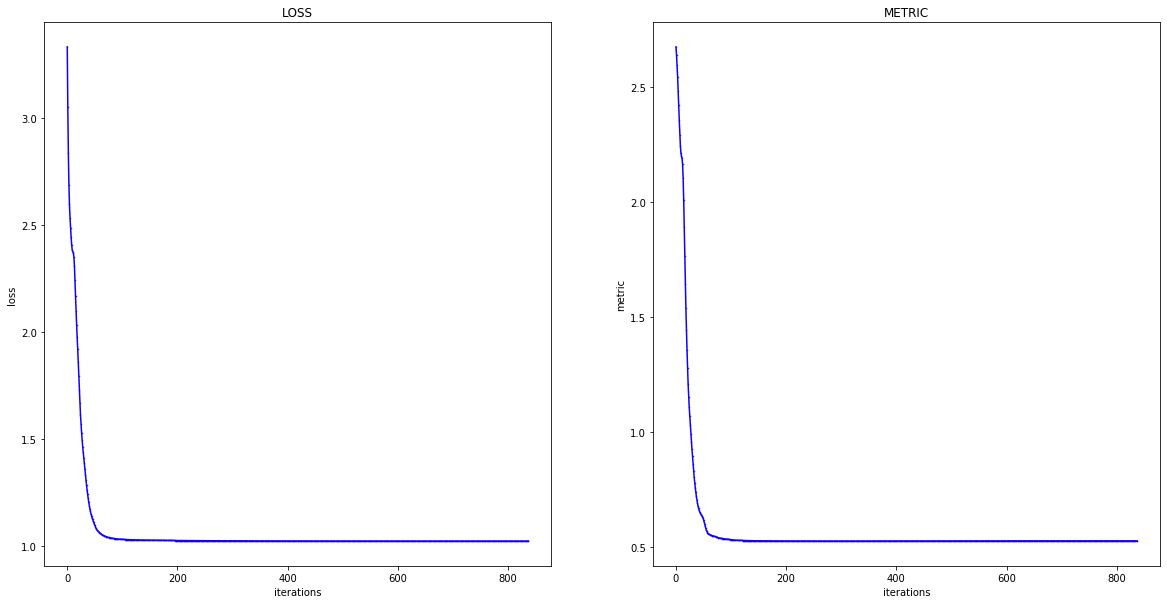

In [14]:
loss = recommender_system.history['loss']
metric = recommender_system.history['metric']

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('LOSS')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('METRIC')
ax2.set_xlabel('iterations')
ax2.set_ylabel('metric')
ax2.plot(metric, marker='.', color='#0F00FF', markersize=1, linestyle='-')